# Data Preparation

In [32]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
import seaborn as sns
import pandas as pd

# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_file = 'convo_fraud.keras'

Keras = 3.8.0
Num GPUs Available:  1


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Dataset

In [34]:
import os
import pandas as pd

# Define the directory for saving the combined dataset
base_dir = "/content/drive/My Drive/SIT_Capstone/"
csv_file = os.path.join(base_dir, "combined_convo_dataset.csv")

# Define the paths for your datasets
splits = {
    'train': 'hf://datasets/BothBosu/scam-dialogue/scam-dialogue_train.csv',
    'test': 'hf://datasets/BothBosu/scam-dialogue/scam-dialogue_test.csv',
    'multi_agent_train': 'hf://datasets/BothBosu/multi-agent-scam-conversation/agent_conversation_train.csv',
    'multi_agent_test': 'hf://datasets/BothBosu/multi-agent-scam-conversation/agent_conversation_test.csv',
    'single_agent_train': 'hf://datasets/BothBosu/single-agent-scam-conversations/single-agent-scam-dialogue_train.csv',
    'single_agent_test': 'hf://datasets/BothBosu/single-agent-scam-conversations/single-agent-scam-dialogue_test.csv'
}
gen_convo_path = "hf://datasets/BothBosu/Scammer-Conversation/gen_conver_noIdentifier_1000.csv"

# Load datasets
try:
    train_df = pd.read_csv(splits['train'])
    test_df = pd.read_csv(splits['test'])
    multi_agent_train_df = pd.read_csv(splits['multi_agent_train'])
    multi_agent_test_df = pd.read_csv(splits['multi_agent_test'])
    single_agent_train_df = pd.read_csv(splits['single_agent_train'])
    single_agent_test_df = pd.read_csv(splits['single_agent_test'])
    gen_convo_df = pd.read_csv(gen_convo_path)

    # Standardize column naming and add a source column
    for source, df in {
        'train': train_df,
        'test': test_df,
        'multi_agent_train': multi_agent_train_df,
        'multi_agent_test': multi_agent_test_df,
        'single_agent_train': single_agent_train_df,
        'single_agent_test': single_agent_test_df,
        'gen_convo': gen_convo_df
    }.items():
        # Rename 'dialogue' or 'conversation' to 'conversation'
        if 'dialogue' in df.columns:
            df.rename(columns={'dialogue': 'conversation'}, inplace=True)
        elif 'conversation' not in df.columns:
            raise ValueError("Missing both 'dialogue' and 'conversation' columns in one of the datasets.")

        # Rename 'labels' to 'label' if present
        if 'labels' in df.columns:
            df.rename(columns={'labels': 'label'}, inplace=True)

        # Add a new column to track the source dataset
        df['source'] = source

    # Combine datasets into one
    combined_df = pd.concat([train_df, test_df, multi_agent_train_df, multi_agent_test_df, single_agent_train_df, single_agent_test_df, gen_convo_df], ignore_index=True)

    # Shuffle dataset (with equal distribution from each dataset)
    # Group by 'source' and shuffle each group
    shuffled_df = combined_df.groupby('source').apply(lambda x: x.sample(frac=1, random_state=42)).reset_index(drop=True)

    # Save the shuffled combined dataset
    shuffled_df.to_csv(csv_file, index=False)
    print("Shuffled combined dataset saved successfully!")

    # Print details
    print("First 5 rows of the shuffled dataset:")
    print(shuffled_df.head())

    # Total count of rows in the shuffled dataset
    total_count = len(shuffled_df)
    print(f"\nTotal number of rows in the shuffled dataset: {total_count}")

    # Count of each label
    if 'label' in shuffled_df.columns:
        label_counts = shuffled_df['label'].value_counts()
        print("Count of each label in shuffled dataset:")
        print(label_counts)
    else:
        print("Warning: No 'label' column found in the shuffled dataset.")

except Exception as e:
    print(f"An error occurred: {e}")


<ipython-input-34-675f08f7ad6d>:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shuffled_df = combined_df.groupby('source').apply(lambda x: x.sample(frac=1, random_state=42)).reset_index(drop=True)


Shuffled combined dataset saved successfully!
First 5 rows of the shuffled dataset:
                                        conversation type  label     source  \
0  Person A: Hey, how's it going? Person B: It's ...  NaN      0  gen_convo   
1  Person A: Good morning, I'm calling from the s...  NaN      1  gen_convo   
2  Person A: Hey, how's it going? Person B: It's ...  NaN      0  gen_convo   
3  Person A: Hey, how's it going? Person B: It's ...  NaN      0  gen_convo   
4  Person A: Hey, how's it going? Person B: It's ...  NaN      0  gen_convo   

  personality  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  

Total number of rows in the shuffled dataset: 5800
Count of each label in shuffled dataset:
label
1    2924
0    2876
Name: count, dtype: int64


# Data Cleaning

In [35]:
# Remove duplicates
shuffled_df = shuffled_df.drop_duplicates()
print(f"Total rows after removing duplicates: {len(shuffled_df)}")

# Print new label_counts
label_counts = shuffled_df['label'].value_counts()
print(label_counts)

Total rows after removing duplicates: 5557
label
0    2839
1    2718
Name: count, dtype: int64


# Ratio of Normal to Fraud data Distribution

Ratio of normal to fraud: 0.91
Normal label percentage: 47.60%
Fraud label percentage: 52.40%


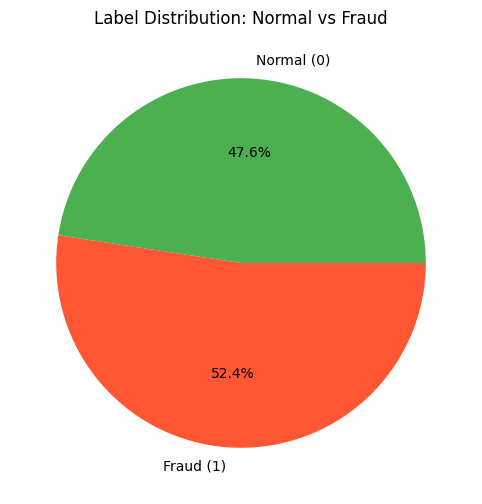

In [36]:
# Count the occurrences of each label dynamically
label_counts = df['label'].value_counts().to_dict()

# Total number of entries
total_count = sum(label_counts.values())

# Extract counts for fraud (1) and normal (0) labels
normal_count = label_counts.get(0, 0)
fraud_count = label_counts.get(1, 0)

# Calculate the ratio of normal to fraud
if fraud_count > 0:  # Avoid division by zero
    ratio = normal_count / fraud_count
else:
    ratio = float('inf')  # If no fraud cases, set ratio to infinity

# Print the ratio and percentages
print(f"Ratio of normal to fraud: {ratio:.2f}")
print(f"Normal label percentage: {(normal_count / total_count) * 100:.2f}%")
print(f"Fraud label percentage: {(fraud_count / total_count) * 100:.2f}%")

# Visualize the label distribution as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(
    [normal_count, fraud_count],
    labels=['Normal (0)', 'Fraud (1)'],
    autopct='%1.1f%%',
    colors=['#4CAF50', '#FF5733']
)
plt.title('Label Distribution: Normal vs Fraud')
plt.show()

# Model Building

In [37]:
pip install transformers datasets torch scikit-learn

In [38]:
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPTNeoForSequenceClassification, AdamW, get_scheduler
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Initialize the GPT-Neo tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-125M", cache_dir="./models")
tokenizer.pad_token = tokenizer.eos_token  # Add padding token for GPT models

# Select only the required columns
X = shuffled_df['conversation']  # Features
y = shuffled_df['label']         # Target

# Split the dataset into training and testing sets with an 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data
def tokenize_texts(texts, tokenizer, max_length=256):
    return tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

print("Tokenizing training data...")
train_encodings = tokenize_texts(X_train, tokenizer)
print("Tokenizing testing data...")
test_encodings = tokenize_texts(X_test, tokenizer)

# Convert labels to torch tensors for binary classification
train_labels = torch.tensor(y_train.values, dtype=torch.long)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Print dataset statistics
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
avg_length = X.apply(lambda x: len(x.split())).mean()
print(f"Average text length: {avg_length}")
print(f"Training label distribution:\n{y_train.value_counts()}")
print(f"Testing label distribution:\n{y_test.value_counts()}")

# Convert tokenized inputs into TensorDataset
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_labels
)

test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    test_labels
)

Tokenizing training data...
Tokenizing testing data...
Training set size: 4445
Testing set size: 1112
Average text length: 316.7876552096455
Training label distribution:
label
0    2276
1    2169
Name: count, dtype: int64
Testing label distribution:
label
0    563
1    549
Name: count, dtype: int64


In [39]:
# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load GPT-Neo model for binary classification
model = GPTNeoForSequenceClassification.from_pretrained(
    "EleutherAI/gpt-neo-125M",
    num_labels=2  # Binary classification
)
model.config.pad_token_id = tokenizer.eos_token_id
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training configurations
epochs = 10
num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)

# Define learning rate scheduler
scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Training and validation loop
history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}
best_val_loss = float("inf")
early_stopping_patience = 3
no_improvement_epochs = 0
model_checkpoint_path = "best_gpt_neo_model.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch in tqdm(train_loader, desc="Training"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        train_loss += loss.item()
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    train_loss /= len(train_loader)
    train_accuracy = train_correct / train_total
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Validation"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            val_loss += outputs.loss.item()
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping and checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_epochs = 0
        torch.save(model.state_dict(), model_checkpoint_path)
        print("Model checkpoint saved.")
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= early_stopping_patience:
        print("Early stopping triggered.")
        break

model.save_pretrained("best_gpt_neo")
tokenizer.save_pretrained("best_gpt_neo")

# Load the best model before evaluation
model.load_state_dict(torch.load(model_checkpoint_path))
print("Training complete. Best model loaded.")

# Display training history
print("\nTraining History:")
print(history)

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/10


Training: 100%|██████████| 278/278 [03:21<00:00,  1.38it/s]


Train Loss: 0.7868, Train Accuracy: 0.6571


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.95it/s]


Validation Loss: 0.2634, Validation Accuracy: 0.8930
Model checkpoint saved.

Epoch 2/10


Training: 100%|██████████| 278/278 [03:26<00:00,  1.35it/s]


Train Loss: 0.0883, Train Accuracy: 0.9762


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.94it/s]


Validation Loss: 0.0319, Validation Accuracy: 0.9901
Model checkpoint saved.

Epoch 3/10


Training: 100%|██████████| 278/278 [03:26<00:00,  1.35it/s]


Train Loss: 0.0072, Train Accuracy: 0.9984


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.94it/s]


Validation Loss: 0.0075, Validation Accuracy: 0.9982
Model checkpoint saved.

Epoch 4/10


Training: 100%|██████████| 278/278 [03:26<00:00,  1.35it/s]


Train Loss: 0.0017, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.94it/s]


Validation Loss: 0.0049, Validation Accuracy: 0.9982
Model checkpoint saved.

Epoch 5/10


Training: 100%|██████████| 278/278 [03:26<00:00,  1.35it/s]


Train Loss: 0.0009, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.94it/s]


Validation Loss: 0.0035, Validation Accuracy: 0.9991
Model checkpoint saved.

Epoch 6/10


Training: 100%|██████████| 278/278 [03:26<00:00,  1.35it/s]


Train Loss: 0.0006, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.93it/s]


Validation Loss: 0.0030, Validation Accuracy: 0.9991
Model checkpoint saved.

Epoch 7/10


Training: 100%|██████████| 278/278 [03:26<00:00,  1.35it/s]


Train Loss: 0.0004, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.93it/s]


Validation Loss: 0.0025, Validation Accuracy: 0.9991
Model checkpoint saved.

Epoch 8/10


Training: 100%|██████████| 278/278 [03:26<00:00,  1.35it/s]


Train Loss: 0.0003, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.93it/s]


Validation Loss: 0.0023, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 9/10


Training: 100%|██████████| 278/278 [03:26<00:00,  1.35it/s]


Train Loss: 0.0003, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.94it/s]


Validation Loss: 0.0021, Validation Accuracy: 1.0000
Model checkpoint saved.

Epoch 10/10


Training: 100%|██████████| 278/278 [03:26<00:00,  1.35it/s]


Train Loss: 0.0003, Train Accuracy: 1.0000


Validation: 100%|██████████| 70/70 [00:17<00:00,  3.94it/s]


Validation Loss: 0.0021, Validation Accuracy: 1.0000
Model checkpoint saved.
Training complete. Best model loaded.

Training History:
{'train_loss': [0.7867578626375833, 0.08826760005326473, 0.007152082557243918, 0.0016658100596176402, 0.0008539488815114978, 0.0005656957457582433, 0.0004279821093778148, 0.0003494763550668513, 0.0003059816591506225, 0.00028669307447926783], 'val_loss': [0.26336828502161164, 0.031873697069074426, 0.007526910859659048, 0.004868195750168525, 0.003512698080989399, 0.003001783636968217, 0.0024575707870618706, 0.002250552681757004, 0.0021030816269298415, 0.0020638686528919995], 'train_accuracy': [0.6571428571428571, 0.9761529808773903, 0.9984251968503937, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_accuracy': [0.8929856115107914, 0.9901079136690647, 0.9982014388489209, 0.9982014388489209, 0.9991007194244604, 0.9991007194244604, 0.9991007194244604, 1.0, 1.0, 1.0]}


# Model Architecture

In [40]:
print(model)

GPTNeoForSequenceClassification(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj)

# Plotting the Learning Curve of the Model

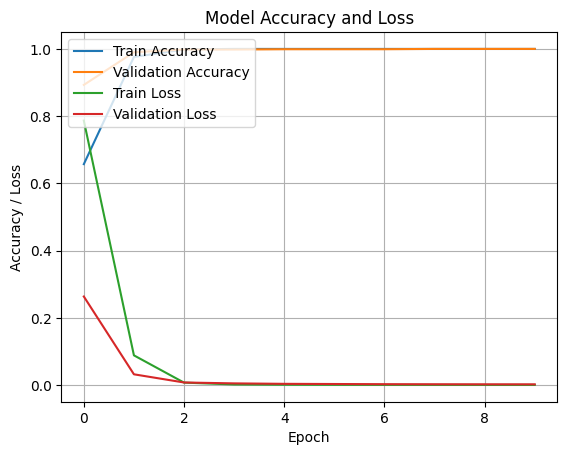

In [41]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history['train_accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')

# Plot Loss
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')

# Add title and labels
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy / Loss')
plt.xlabel('Epoch')

# Add legend
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)  # Optional for better readability
plt.show()

# Precision, Recall, F1-Score


In [42]:
from sklearn.metrics import classification_report

# Ensure model is in evaluation mode
model.eval()

# Prepare the test data
test_encodings = tokenize_texts(X_test, tokenizer)
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test.values, dtype=torch.float32)  # Make sure labels are tensors
)

# DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# No gradients needed for inference
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)  # Adjust for binary classification

        # Convert logits to probabilities
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()  # Convert probabilities to binary labels

        # Modify how predictions are extracted from the logits
        preds = torch.argmax(probs, dim=-1)  # Get the class with the highest probability

        # Store true labels and predictions
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

# Generate classification report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       563
         1.0       1.00      1.00      1.00       549

    accuracy                           1.00      1112
   macro avg       1.00      1.00      1.00      1112
weighted avg       1.00      1.00      1.00      1112



# Confusion Matrix

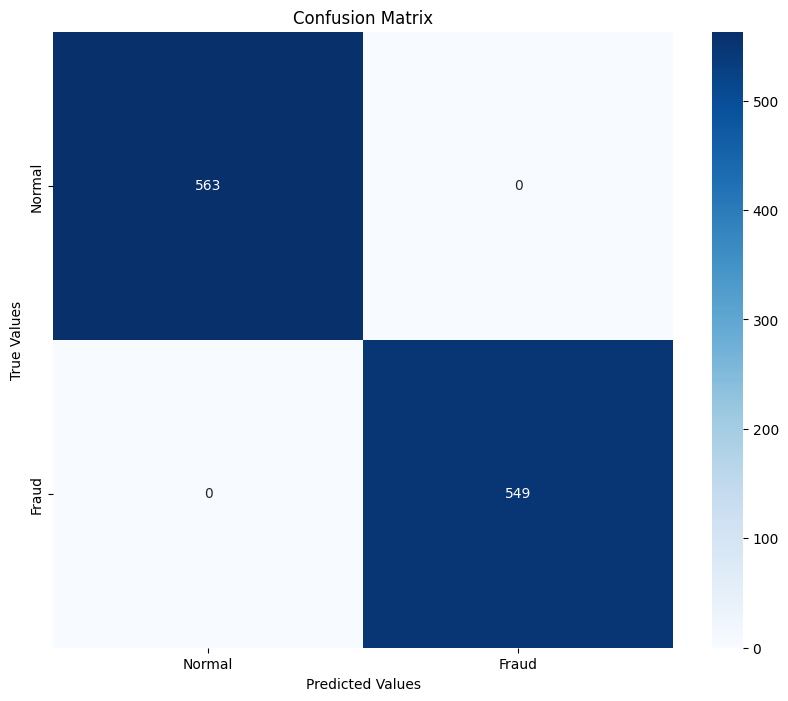

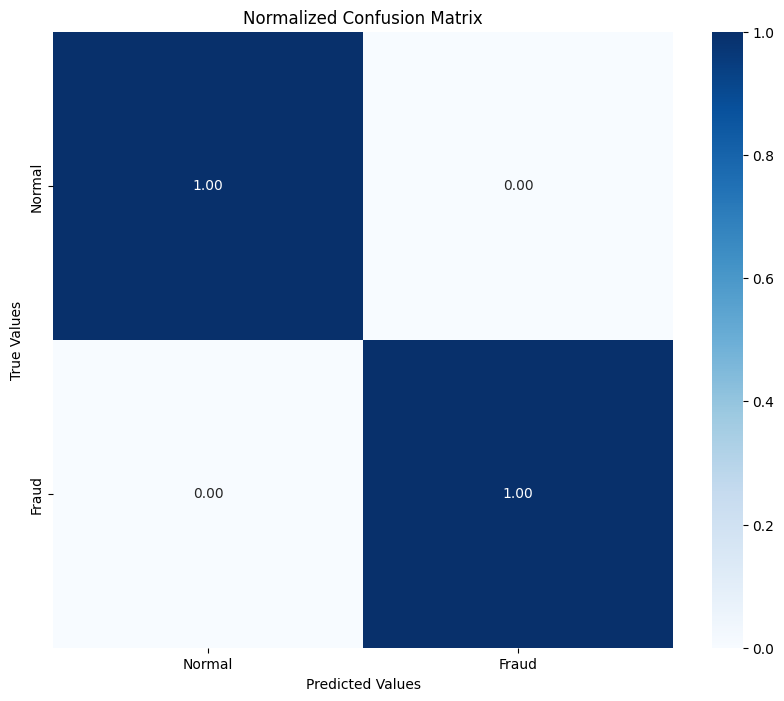

DSC: 1.0, Sensitivity: 1.0, Specificity: 1.0, Accuracy: 1.0


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import torch

def calculate_metrics(y_true, y_pred, classes=['Normal', 'Fraud']):
    """
    Calculate and display various evaluation metrics based on true and predicted labels.

    Parameters:
    - y_true: Array of true labels.
    - y_pred: Array of predicted labels.
    - classes: List of class labels (default: ['Normal', 'Fraud']).

    Returns:
    - dsc: Dice similarity coefficient (mean across classes).
    - sensitivity: Mean sensitivity across classes.
    - specificity: Mean specificity across classes.
    - accuracy: Overall accuracy.
    """
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Confusion Matrix')
    plt.show()

    # Normalize the confusion matrix by row (true labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate the Dice similarity coefficient (DSC) for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])

    # Calculate the sensitivity (recall) for each class and average them
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])

    # Calculate the specificity for each class and average them
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Calculate the overall accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Print the evaluation metrics
    print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

    return dsc, sensitivity, specificity, accuracy

# Make sure model is in evaluation mode
model.eval()

# Prepare the test data (tokenized input data for PyTorch)
test_encodings = tokenize_texts(X_test, tokenizer)
test_dataset = TensorDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    torch.tensor(y_test.values, dtype=torch.float32)  # Ensure labels are tensors
)

# DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# No gradients needed for inference
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze(-1)

        # Get the predicted probabilities
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()  # Use thresholding to get the predicted labels (0 or 1)

        # Modify how predictions are extracted from the logits
        preds = torch.argmax(probs, dim=-1)  # Get the class with the highest probability

        # Append true labels and predicted labels
        true_labels.extend(labels.cpu().numpy())  # Move labels back to CPU for numpy operations
        predictions.extend(preds.cpu().numpy())   # Move predictions back to CPU for numpy operations

# Calculate metrics
dsc, sensitivity, specificity, accuracy = calculate_metrics(true_labels, predictions)

In [44]:
!pip install transformers torch gradio

In [45]:
import torch
from transformers import GPT2Tokenizer, GPTNeoForSequenceClassification
import gradio as gr

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load tokenizer and trained model
tokenizer = GPT2Tokenizer.from_pretrained("best_gpt_neo")  # Ensure correct tokenizer
model = GPTNeoForSequenceClassification.from_pretrained("best_gpt_neo").to(device)  # Load full model
model.eval()

def classify_caller_message(caller_messages, scam_detected=False):
    scam_threshold = 0.7 if scam_detected else 0.5
    if not caller_messages:
        return "No caller messages to analyze.", scam_detected

    input_text = " ".join([f"Caller: {text}" for text in caller_messages])
    inputs = tokenizer(input_text, padding=True, truncation=True, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)
    prediction = probabilities[:, 1].item()  # Class 1 probability

    is_scam = prediction > scam_threshold
    response = "🚨 Scam Alert: This message might be a scam!" if is_scam else "✅ Caller message seems safe."
    return response, is_scam

# Gradio Chat Interface
def chat_interface(speaker, message, conversation_log=[], caller_messages=[], scam_detected=False):
    """
    Handles the chat flow while ensuring only the caller's messages affect scam classification.
    """
    conversation_log.append((speaker, message))  # Append to full log

    if speaker == "caller":
        caller_messages.append(message)  # Only keep caller messages for classification
        response, scam_detected = classify_caller_message(caller_messages, scam_detected)
        conversation_log.append(("System", response))
    else:
        response = "✅ Receiver message recorded (ignored for scam detection)."  # Receiver messages do not affect model
        conversation_log.append(("System", response))

    return conversation_log, caller_messages, scam_detected, ""  # Updated states & reset input

# Create Gradio UI
with gr.Blocks() as demo:
    chatbot = gr.Chatbot(label="Conversation Log")
    speaker = gr.Dropdown(["caller", "receiver"], label="Speaker")
    msg = gr.Textbox(placeholder="Enter message...")
    clear = gr.Button("Clear Chat")

    # Maintain separate states
    caller_messages = gr.State([])  # Stores only caller messages
    scam_flag = gr.State(False)  # Tracks scam detection

    msg.submit(chat_interface, [speaker, msg, chatbot, caller_messages, scam_flag],
               [chatbot, caller_messages, scam_flag, msg])

    clear.click(lambda: ([], [], False, ""), outputs=[chatbot, caller_messages, scam_flag, msg])

# Launch Gradio App
demo.launch(share=True)


<ipython-input-45-4eb9ef003eda>:50: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Conversation Log")


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e845e4ee2cf0b5ad57.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
